## Final Project Submission

Please fill out:
* Student name: Abdulrahman Aber, Benjamin Bai, Charles Pan, Kevin Rivera
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: David Elliott
* Blog post URL:


# Imports, Data Frame Initializations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3 as sq
import seaborn as sns
import statistics as st
import datetime
conn = sq.connect('./zippedData/im.db/im.db')
cur = conn.cursor()

OperationalError: unable to open database file

In [ ]:
movie_basics_df = pd.read_sql('''select * from movie_basics''', conn)

In [ ]:
movie_ratings_df = pd.read_sql("""select * from movie_ratings""",conn)

In [ ]:
persons_df = pd.read_sql("""select * from persons""",conn)

In [ ]:
principals_df = pd.read_sql("""select * from principals""",conn)

In [ ]:
tmdb_movies_df = pd.read_csv('./zippedData/tmdb.movies.csv.gz')

In [2]:
tn_movie_budgets_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz',
                                 parse_dates=['release_date'])

In [3]:
tn_movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


tn_movie_budgets_df.info() shows us that this dataframe will be used to derive net_return and ROI as a percentage, specifically production_budget and worldwide_gross. We believe net_return and ROI% are the key metrics for an executive team weighing different investment options. 

# TN Movie Budgets Clean Up Process (Ben)

In [4]:
# Remove $ from production_budget, convert to float
tn_movie_budgets_df['production_budget'] = tn_movie_budgets_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from domestic_gross, convert to float
tn_movie_budgets_df['domestic_gross'] = tn_movie_budgets_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from worldwide_gross, convert to float
tn_movie_budgets_df['worldwide_gross'] = tn_movie_budgets_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# new column release_year from release_date to filter based on time frame in scope
tn_movie_budgets_df['release_year'] = pd.DatetimeIndex(tn_movie_budgets_df['release_date']).year

# time frame: 2010-Present; SAG definition of theatrical budget: > 2 million
tn_movie_budgets_df = tn_movie_budgets_df[(tn_movie_budgets_df.release_year >= 2010) & (tn_movie_budgets_df.production_budget > 1999999)]

# Recommendation 1: Genres Analysis
TN Movie Budgets merge with IMDB Movie Basics

In [5]:
# rename movie_basics column to match tn_movie_budgets
movie_basics_df.rename(columns={"primary_title":"movie"}, inplace = True)

# merge movie_budgets and imdb movie_basics
moviebudgets_moviebasics_df = tn_movie_budgets_df.merge(movie_basics_df, how='inner', on='movie')

# drop columns that are not relevant to Genre analysis
moviebudgets_moviebasics_df.drop(columns = ['id','release_date', 'movie_id', 'original_title', 'runtime_minutes', 'domestic_gross' ],axis=1,inplace=True)

# remove duplicate movies
moviebudgets_moviebasics_df.drop_duplicates(subset='movie', keep='first', inplace=True, ignore_index=False)

# add column for net_return
moviebudgets_moviebasics_df['net_return'] = (moviebudgets_moviebasics_df['worldwide_gross'] - moviebudgets_moviebasics_df['production_budget'])

# add column for ROI as a %
moviebudgets_moviebasics_df['roi_percent'] = ((moviebudgets_moviebasics_df['net_return'] / moviebudgets_moviebasics_df['production_budget'])*100)

NameError: name 'movie_basics_df' is not defined

# Recommendation 1: Visualizations

In [6]:
# genres to list 
moviebudgets_moviebasics_df['genres'] = moviebudgets_moviebasics_df['genres'].str.split(",")
# explode out rows for movies with multiple genres for visualization purposes
moviebudgets_moviebasics_df = moviebudgets_moviebasics_df.explode('genres')
# means grouped by genre
moviebudgets_moviebasics_mean_df = moviebudgets_moviebasics_df.groupby(['genres']).mean().reset_index()

NameError: name 'moviebudgets_moviebasics_df' is not defined

In [ ]:
# visualization 1: initialize relevant dataframes and lists for x/y values
netreturn_vis = moviebudgets_moviebasics_df.dropna()

n_list = list(moviebudgets_moviebasics_df['genres'].value_counts().head(10).keys())

netreturn_vis = netreturn_vis[netreturn_vis['genres'].isin(n_list)]

In [ ]:
# visualization 1: net return bar plot

# seaborn style
sns.set(style='whitegrid')

# initialize matlab plot
fig, ax = plt.subplots(figsize=(16, 8))

# define df, x and y values
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['net_return'])

net_return_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)

sns.barplot(x=x_values, y=y_values, data=roi_vis, palette='muted')
ax.set_title('Genre vs Avg. Net Return', fontsize = 20, pad=24)
plt.xlabel('Genre', fontsize = 18, labelpad=18)
plt.ylabel('Net Return (Hundreds of Millions)', fontsize = 18, labelpad=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('net_return_visualization.png', bbox_inches='tight')

In [ ]:
# visualization 2: ROI% bar plot

# seaborn style
sns.set(style='whitegrid')

# initialize matlab plot
fig, ax = plt.subplots(figsize=(16, 8))

# define df, x and y values
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='roi_percent', ascending=False).head(10)
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['roi_percent'])

# plot
sns.barplot(x=x_values, y=y_values,  data=roi_vis, palette='muted')
ax.set_title('Genre vs Avg. ROI', fontsize = 20, pad=24)
plt.xlabel('Film Genre', fontsize = 18, labelpad=18)
plt.ylabel('ROI %',  fontsize = 18, labelpad=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('roi_percent_visualization.png', bbox_inches='tight')

# TN Movie Budgets Clean Up Process (Kevin)

In [7]:

tn_movies = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
                                
#Get rid of punctuation on worldwide_gross column
tn_movies['worldwide_gross'] = tn_movies['worldwide_gross'].replace('[\$,]', '', regex=True)

#Get rid of punctuation on domestic_gross column
tn_movies['domestic_gross'] = tn_movies['domestic_gross'].replace('[\$,]', '', regex=True)

#Get rid of punctuation on production_budget column
tn_movies['production_budget'] = tn_movies['production_budget'].replace('[\$,]', '', regex=True)

#change worldwide_gross column to float
tn_movies['worldwide_gross'] = tn_movies['worldwide_gross'].astype(float)

#change domestic_gross column to int
tn_movies['domestic_gross'] = tn_movies['domestic_gross'].astype(int)

#change production_budget column to int
tn_movies['production_budget']=tn_movies['production_budget'].astype(int)

In [9]:
tn_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   int32  
 4   domestic_gross     5782 non-null   int32  
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(1), int32(2), int64(1), object(2)
memory usage: 226.0+ KB


# Recommendation 2: Release Month Analysis

With this recommendation we decided to use the return on investment(ROI) percentage to see if there was a trend in getting more ROI from releasing a movie in a certain month.
The process that was used to get this percentage was taking the worldwide gross column minus production budget to get net income, then dividing net income by production budget to end up with an ROI percentage

In [10]:
#create a net_income column by taking domestic_gross and subtracting production budget
tn_movies["net_income"]=tn_movies['worldwide_gross']-tn_movies['production_budget']

#create a cost_revenue_ratio by taking net income and dividing it by production budget
tn_movies["ROI"]=((tn_movies['net_income'])/(tn_movies['production_budget']))*100

#change all cost_rev values into int 
tn_movies["ROI"] =tn_movies["ROI"].astype(int)

#change release_date column into datetime format
tn_movies["release_date"] = pd.to_datetime(tn_movies["release_date"])

#create a month and year column
tn_movies['year'] = pd.DatetimeIndex(tn_movies['release_date']).year
tn_movies['month'] = pd.DatetimeIndex(tn_movies['release_date']).month

# time frame: 2010-Present & SAG definition of theatrical budget: > 2 million
tn_movies_2010 = tn_movies[(tn_movies['production_budget'] > 1999999) & (tn_movies['year'] >= 2010)]

# Recommendation 2: Month Release Visualization

In [11]:
#created a list with all the Cost_Rev_Ratios in tn_movies_2010
ROI = [x for x in tn_movies_2010["ROI"]] 
#created a list of all the month value associated with each cost_rev_ratio
Month = [x for x in tn_movies_2010['month']]
#mapped both list into a master list as tuples
ROI_Month = list(map(lambda *x: x, Month, ROI))
#created a function that would take in associated number and append a new list of Cost_Rev_Ratio based on associated month value
#get the mean of the list by associated month  
def month_mean(num):
    x = []
    for index, tuple in enumerate(ROI_Month):
        element_one = tuple[0]
        element_two = tuple[1]
        if element_one == num:
            x.append(element_two)
    return(st.mean(x))
#created a function that would take in associated number and append a new list of Cost_Rev_Ratio based on associated month value
#get the median of the list by associated month 
def month_median(num):
    x = []
    for index, tuple in enumerate(ROI_Month):
        element_one = tuple[0]
        element_two = tuple[1]
        if element_one == num:
            x.append(element_two)
    return(st.median(x))

In [12]:
#created dictionary to map month_index to month_list
month_index = [1,2,3,4,5,6,7,8,9,10,11,12]
month_list = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
mapped_months = dict(map(lambda *x: x, month_index, month_list))

In [13]:
#made two list using functions above of all medians per month and means per month 
by_month_mean_list = []
by_month_median_list = []
for num in mapped_months.keys():
    by_month_mean_list.append(month_mean(num))
    by_month_median_list.append(month_median(num))

In [14]:
#created two dictionaries that mapped values of the two list above to associated month 
month_mean = dict(map(lambda *x: x, month_list, by_month_mean_list))
month_median = dict(map(lambda *x: x, month_list, by_month_median_list))

In [15]:
month_mean

{'Jan': 242.28571428571428,
 'Feb': 215.30714285714285,
 'Mar': 151.95209580838323,
 'Apr': 156.03947368421052,
 'May': 211.47058823529412,
 'June': 234.1631205673759,
 'July': 288.6136363636364,
 'Aug': 194.85034013605443,
 'Sept': 159.99397590361446,
 'Oct': 270.6309523809524,
 'Nov': 233.86335403726707,
 'Dec': 136.70697674418605}

In [16]:
month_median

{'Jan': 76.0,
 'Feb': 98.5,
 'Mar': 77,
 'Apr': 66.0,
 'May': 127.0,
 'June': 103,
 'July': 167.5,
 'Aug': 94,
 'Sept': 67.0,
 'Oct': 50.0,
 'Nov': 125,
 'Dec': 72}

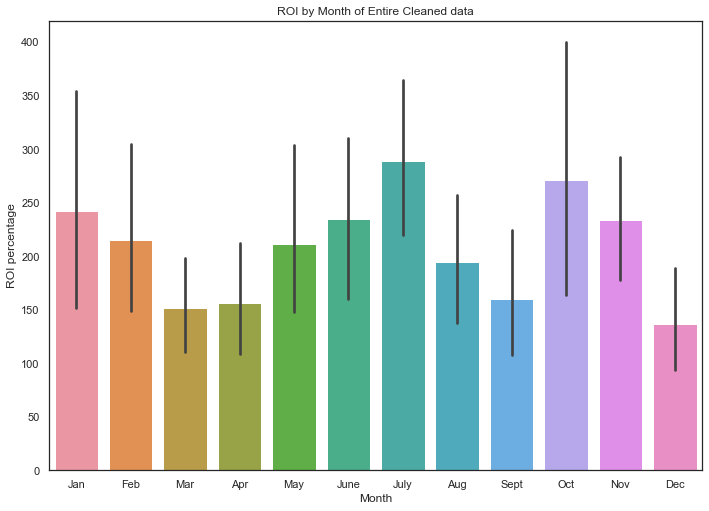

In [23]:
df = pd.DataFrame({'Month': Month,
                   'ROI': ROI,})
#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
ax = sns.barplot(x='Month', y='ROI',  data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set(ylabel='ROI percentage',title='ROI by Month of Entire Cleaned data')
ax.set_xticklabels(month_list);

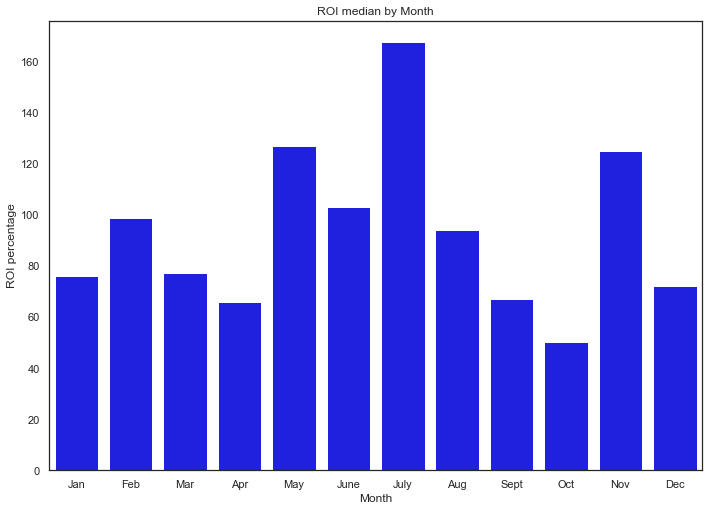

In [18]:
df2 = pd.DataFrame({'Month': month_median.keys(),
                   'ROI': month_median.values(),})
#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
ax = sns.barplot(x='Month', y='ROI',  data=df2, color='blue')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set(xlabel='Month', ylabel='ROI percentage',title='ROI median by Month');

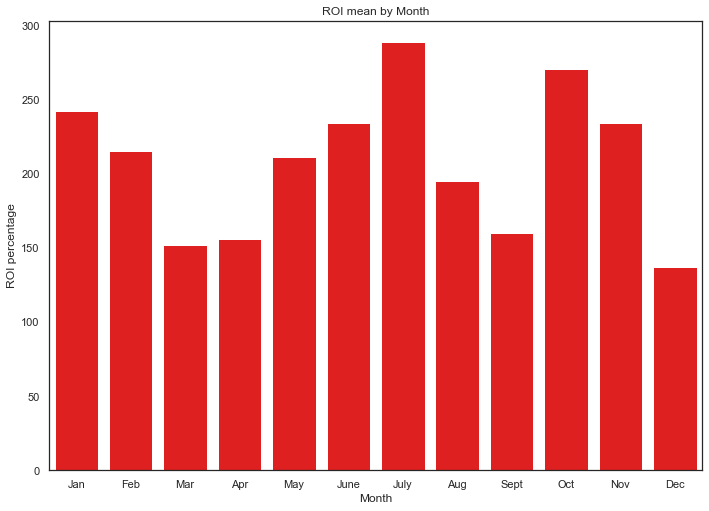

In [19]:
df1 = pd.DataFrame({'Month': month_mean.keys(),
                   'ROI': month_mean.values(),})
#set seaborn plotting aesthetics
sns.set(style='white')

#create grouped bar chart
ax = sns.barplot(x='Month', y='ROI',  data=df1,color='red')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set(xlabel='Month', ylabel='ROI percentage',title='ROI mean by Month');

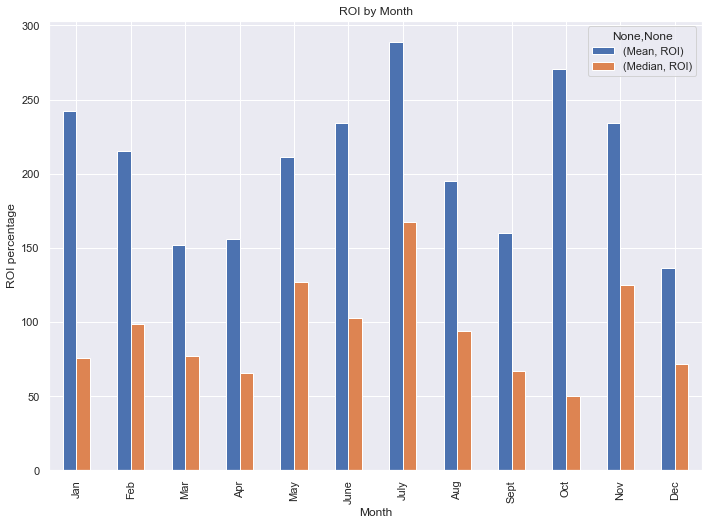

In [24]:
ax = pd.concat({
    'Mean': df1.set_index('Month'), 'Median': df2.set_index('Month'),
}, axis=1).plot.bar()
ax.set(xlabel='Month', ylabel='ROI percentage',title='ROI by Month')
sns.set(rc={'figure.figsize':(11.7,8.27)});

# Recommendation 2: Analysis outcome 

Based on the different visualization trends we came to the conclusion that the best month of release would be July.